In [1]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

enrollment_folder = "enrollment"
verification_folder = "verification"

def list_signature_files(folder, pattern):
    return sorted(glob.glob(os.path.join(folder, pattern)))

def extract_xy_from_tsv(tsv_path):
    df = pd.read_csv(tsv_path, sep="\t")
    x = df.iloc[:, 1].values
    y = df.iloc[:, 2].values
    return np.stack([x, y], axis=1)

def resample_signature(sig_xy, num_points=128):
    t = np.linspace(0, 1, len(sig_xy))
    t_resampled = np.linspace(0, 1, num_points)
    x_interp = interp1d(t, sig_xy[:, 0], kind='linear')(t_resampled)
    y_interp = interp1d(t, sig_xy[:, 1], kind='linear')(t_resampled)
    return np.stack([x_interp, y_interp], axis=1)

def normalize_signature(sig_xy):
    mu = sig_xy.mean(axis=0)
    sigma = sig_xy.std(axis=0)
    sigma[sigma == 0] = 1
    return (sig_xy - mu) / sigma

def load_signatures(folder, writer_id, is_enrollment=False):
    pattern = f"{writer_id}-g-*.tsv" if is_enrollment else f"{writer_id}-*.tsv"
    file_list = list_signature_files(folder, pattern)
    signatures = {}
    for fpath in file_list:
        sig_id = os.path.splitext(os.path.basename(fpath))[0]
        sig_xy = extract_xy_from_tsv(fpath)
        sig_xy = resample_signature(sig_xy, num_points=128)
        sig_xy = normalize_signature(sig_xy)
        signatures[sig_id] = sig_xy
    return signatures

def get_all_writer_ids(enrollment_folder):
    files = list_signature_files(enrollment_folder, "*.tsv")
    writer_ids = sorted(set([os.path.basename(f)[:3] for f in files]))
    return writer_ids

writer_ids = get_all_writer_ids(enrollment_folder)

enrollment_data = {}
verification_data = {}

for writer_id in writer_ids:
    enrollment_data[writer_id] = load_signatures(enrollment_folder, writer_id, is_enrollment=True)
    verification_data[writer_id] = load_signatures(verification_folder, writer_id, is_enrollment=False)


In [2]:


from dtaidistance import dtw

def dtw_distance_2d(sig1, sig2):
    """
    Compute DTW distance between two 2D signatures by summing DTW(X) + DTW(Y).
    Each signature: shape (num_points, 2)
    """
    x1, y1 = sig1[:, 0], sig1[:, 1]
    x2, y2 = sig2[:, 0], sig2[:, 1]
    dist_x = dtw.distance(x1, x2)
    dist_y = dtw.distance(y1, y2)
    return dist_x + dist_y



# Output: Store minimum DTW dissimilarity per verification signature
dissimilarity_scores = {}  # {writer_id: {verification_sig_id: min_dtw, ...}}

for writer_id in writer_ids:
    dissimilarity_scores[writer_id] = {}
    enroll_sigs = list(enrollment_data[writer_id].values())
    for verif_id, verif_sig in verification_data[writer_id].items():
        # Compute axis-wise DTW to all enrollment signatures
        dtw_scores = []
        for enroll_sig in enroll_sigs:
            score = dtw_distance_2d(verif_sig, enroll_sig)
            dtw_scores.append(score)
        # Aggregate (use minimum score)
        min_score = min(dtw_scores)
        dissimilarity_scores[writer_id][verif_id] = min_score

# Example: print results for first writer
writer_example = writer_ids[0]
sorted_scores = sorted(dissimilarity_scores[writer_example].items(), key=lambda x: x[1])
print(f"Classic DTW (X+Y) scores for writer {writer_example}:")
for sig_id, score in sorted_scores:
    print(f"{sig_id}: {score:.4f}")



Classic DTW (X+Y) scores for writer 001:
001-18: 4.1181
001-17: 4.1491
001-26: 4.1785
001-29: 4.2773
001-02: 4.3741
001-01: 4.5914
001-19: 4.7135
001-22: 4.7624
001-43: 4.9482
001-11: 5.0096
001-14: 5.0793
001-05: 5.1530
001-08: 5.4088
001-13: 5.5443
001-37: 5.6356
001-09: 6.0454
001-23: 6.1666
001-33: 6.2143
001-16: 6.2387
001-03: 6.8397
001-28: 6.9390
001-07: 7.0210
001-32: 7.5893
001-25: 8.0479
001-38: 10.4399
001-36: 10.9886
001-24: 11.0300
001-15: 11.3004
001-20: 11.3077
001-40: 11.7684
001-10: 11.8449
001-44: 12.2700
001-12: 12.5064
001-39: 13.5092
001-04: 13.7439
001-31: 14.4308
001-34: 15.1542
001-35: 15.2511
001-41: 15.4067
001-06: 16.0624
001-30: 16.1313
001-42: 16.4137
001-27: 16.4934
001-21: 17.1562
001-45: 20.2531


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from scipy.optimize import brentq
from scipy.interpolate import interp1d

def evaluate_signature_verification(dissimilarity_scores, ground_truth):
    """
    Evaluates the signature verification system.

    Parameters:
    - dissimilarity_scores: dict
        A dictionary with writer IDs as keys and another dictionary as values,
        which maps verification signature IDs to their corresponding dissimilarity scores.
    - ground_truth: dict
        A dictionary with writer IDs as keys and another dictionary as values,
        which maps verification signature IDs to their corresponding labels (1 for genuine, 0 for forgery).
    """

    y_true = []
    y_scores = []

    for writer_id in dissimilarity_scores:
        for sig_id in dissimilarity_scores[writer_id]:
            score = dissimilarity_scores[writer_id][sig_id]
            label = ground_truth[writer_id][sig_id]
            y_scores.append(-score)  # Invert score: lower dissimilarity implies higher similarity
            y_true.append(label)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    # Compute EER
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

    # Compute confusion matrix at EER threshold
    y_pred = (y_scores >= eer_threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Print evaluation metrics
    print(f"AUC: {auc:.4f}")
    print(f"EER: {eer:.4f} at threshold {eer_threshold:.4f}")
    print("Confusion Matrix at EER threshold:")
    print(cm)

# Example usage:
# dissimilarity_scores = {
#     'writer1': {'sig1': 0.5, 'sig2': 0.7, ...},
#     'writer2': {'sig1': 0.6, 'sig2': 0.8, ...},
#     ...
# }
# ground_truth = {
#     'writer1': {'sig1': 1, 'sig2': 0, ...},
#     'writer2': {'sig1': 1, 'sig2': 0, ...},
#     ...
# }
# evaluate_signature_verification(dissimilarity_scores, ground_truth)


In [7]:
import pandas as pd

# Load the ground truth file
gt_df = pd.read_csv('gt.tsv', sep='\t', header=None, names=['sig_id', 'label'])

# Convert to a nested dictionary: ground_truth[writer_id][signature_id] = 1 (genuine) or 0 (forgery)
ground_truth = {}

for _, row in gt_df.iterrows():
    full_id = row['sig_id']  # e.g., '001-01'
    writer_id, sig_num = full_id.split('-')
    writer_id = writer_id.strip()
    sig_id = full_id.strip()

    label = 1 if row['label'].strip().lower() == 'genuine' else 0
    if writer_id not in ground_truth:
        ground_truth[writer_id] = {}
    ground_truth[writer_id][sig_id] = label


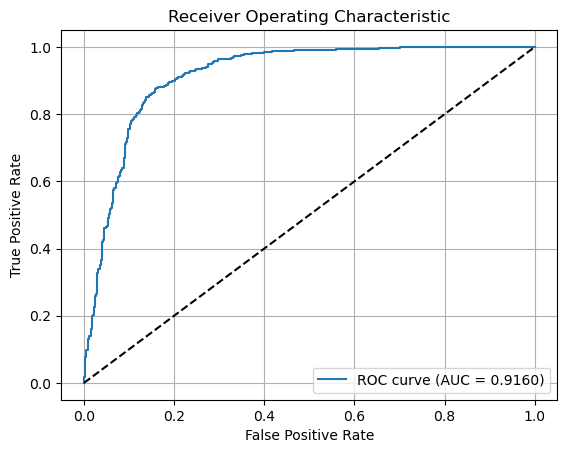

AUC: 0.9160
EER: 0.1453 at threshold -5.9011
Confusion Matrix at EER threshold:
[[641 109]
 [ 89 511]]


In [8]:
evaluate_signature_verification(dissimilarity_scores, ground_truth)
